Esta versión no tiene nada especial, la red simplemente devuelve un vector x que supongo yo que es el minimo del problema

# Parte 1: obtenemos los datos

In [1]:
import numpy as np
import deep_inv_opt as io
import deep_inv_opt.plot as iop
import torch

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.max_open_warning'] = 0  # Let the plots flow!
%matplotlib inline

In [2]:
u_train = io.tensor(np.linspace(-1.5, 1.5, 2048).reshape((-1, 1)))
u_train

tensor([[-1.5000],
        [-1.4985],
        [-1.4971],
        ...,
        [ 1.4971],
        [ 1.4985],
        [ 1.5000]], dtype=torch.float64)

In [3]:
u_val = io.tensor(np.linspace(-2, 2, 128).reshape((-1, 1)))
u_val

tensor([[-2.0000],
        [-1.9685],
        [-1.9370],
        [-1.9055],
        [-1.8740],
        [-1.8425],
        [-1.8110],
        [-1.7795],
        [-1.7480],
        [-1.7165],
        [-1.6850],
        [-1.6535],
        [-1.6220],
        [-1.5906],
        [-1.5591],
        [-1.5276],
        [-1.4961],
        [-1.4646],
        [-1.4331],
        [-1.4016],
        [-1.3701],
        [-1.3386],
        [-1.3071],
        [-1.2756],
        [-1.2441],
        [-1.2126],
        [-1.1811],
        [-1.1496],
        [-1.1181],
        [-1.0866],
        [-1.0551],
        [-1.0236],
        [-0.9921],
        [-0.9606],
        [-0.9291],
        [-0.8976],
        [-0.8661],
        [-0.8346],
        [-0.8031],
        [-0.7717],
        [-0.7402],
        [-0.7087],
        [-0.6772],
        [-0.6457],
        [-0.6142],
        [-0.5827],
        [-0.5512],
        [-0.5197],
        [-0.4882],
        [-0.4567],
        [-0.4252],
        [-0.3937],
        [-0.

ahora generamos los x correspondientes del modelo real

In [4]:
class ExamplePLP(io.ParametricLP):
    # Generate an LP from a given feature vector u and weight vector w.
    def generate(self, u, w):
        c = [[torch.cos(w[0] + w[1]*u)],
             [torch.sin(w[0] + w[1]*u)]]

        A_ub = [[-1.0,  0.0],
                [ 0.0, -1.0],
                [ w[0], 1 + w[1]*u/3]]

        b_ub = [[ 0.2*w[0]*u],
                [-0.2*w[1]*u],
                [ w[0] + 0.1*u]]
        
        return c, A_ub, b_ub, None, None

In [5]:
plp_true = ExamplePLP(weights=[1.0, 1.0])

# Generate training targets by solve the true PLP at each u value.
#x_train = torch.cat([io.linprog(*plp_true(ui)).detach().t() for ui in u_train])
#torch.save(x_train, "x_train.pt")

In [6]:

#x_val = torch.cat([io.linprog(*plp_true(ui)).detach().t() for ui in u_val])
#torch.save(x_val, "x_val.pt")

In [7]:
x_val = torch.load("x_val.pt")
x_val

tensor([[ 0.4000,  1.2000],
        [ 0.3937,  1.1908],
        [ 0.3874,  1.1822],
        [ 0.3811,  1.1741],
        [ 0.3748,  1.1664],
        [ 0.3685,  1.1592],
        [ 0.3622,  1.1523],
        [ 0.3559,  1.1458],
        [ 0.3496,  1.1396],
        [ 0.3433,  1.1337],
        [ 0.3370,  1.1281],
        [ 0.3307,  1.1228],
        [ 0.3244,  1.1177],
        [ 0.3181,  1.1128],
        [ 0.3118,  1.1082],
        [ 0.3055,  1.1037],
        [ 0.2992,  1.0995],
        [ 0.2929,  1.0954],
        [ 0.2866,  1.0914],
        [ 0.2803,  1.0877],
        [ 0.2740,  1.0840],
        [ 0.2677,  1.0805],
        [ 0.2614,  1.0772],
        [ 0.2551,  1.0739],
        [ 0.2488,  1.0708],
        [ 0.2425,  1.0678],
        [ 0.2362,  1.0649],
        [ 0.2299,  1.0621],
        [ 0.2236,  1.0594],
        [ 0.2173,  1.0567],
        [ 0.2110,  1.0542],
        [ 0.2047,  1.0516],
        [ 0.1984, -0.1977],
        [ 0.1921, -0.1920],
        [ 0.1858, -0.1858],
        [ 0.1795, -0

In [8]:
x_train = torch.load("x_train.pt")
x_train

tensor([[0.3000, 1.1000],
        [0.2997, 1.0998],
        [0.2994, 1.0996],
        ...,
        [0.7009, 0.2994],
        [0.7004, 0.2997],
        [0.7000, 0.3000]], dtype=torch.float64)

# Parte 2: definimos la red y la entrenamos

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [10]:
# ver si estoy usando GPU
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
learning_rate = 1e-3
batch_size = 32
tol = 1e-1

In [12]:
# definimos el dataset
class UDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data.clone().to(dtype=torch.float32) # nota: esta dando el warning porque estoy convirtiendo un tensor a otro, en ese caso es mejor usar clone()
        # si los datos de entrada no los voy a dar como un tensor, entonces hay que poner lo que he puesto: self.data = torch.tensor(data, dtype=torch.float32), self.targets = torch.tensor(targets, dtype=torch.float32)
        self.targets = targets.clone().to(dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Dataset con pares (u, x)
dataset = UDataset(u_train, x_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
val_dataset = UDataset(u_val, x_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [14]:
def near(rs, x_batch, tol=1e-3):
    '''
    rs: tensor formado por las soluciones de los LPs
    x_batch: tensor formado por las soluciones deseadas de los LPs
    tol: tolerancia para considerar que dos vectores son iguales

    Esta función calcula el número de soluciones de los LPs que están 
    a una distancia menor que tol de las soluciones deseadas.
    '''
    matriz_diferencias = rs - x_batch # matriz de diferencias entre las soluciones de los LPs y las soluciones deseadas
    matriz_al_cuadrado = matriz_diferencias ** 2 # elevo cada elemento al cuadrado
    distancias = torch.sum(matriz_al_cuadrado, dim=1) # sumo los elementos de cada fila
    return torch.sum(distancias < tol).item()

Esta version es la red neuronal en la que la resolucion del problema de optimizacion esta dentro de la red

In [15]:
# definimos la red (hay que revisar la forma de la red y el por qué)
class ParametricLPNet(nn.Module):
    def __init__(self):
        super(ParametricLPNet, self).__init__()
        # Entrada de dimensión 1, salida 8 (2 para c, 4 para A, 2 para b)
        self.fc = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, u):
        output = self.fc(u)
        return output


In [16]:
# Función de pérdida
loss_fn = nn.MSELoss()

# Crear la red neuronal
model = ParametricLPNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # elegir una de las dos

In [17]:
# para ver el modelo
model

ParametricLPNet(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [18]:
# inicializamod los pesos de la red 
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu') # inicializamos los pesos de la red con Kaiming
        nn.init.zeros_(m.bias) # inicializamos los bias a 0

initialize_weights(model)

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_media = 0.0
    accuracy = 0.0
    batch_size = dataloader.batch_size
    for batch, (u_batch, x_batch) in enumerate(dataloader):

        rs = model(u_batch)
        loss = loss_fn(rs, x_batch) # Calcular la pérdida

        # Backpropagation y optimización
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 8 == 0: # cambiar este numero para que salga cada cierto numero de iteraciones
            loss = loss.item()
            current = batch * batch_size + batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        loss_media += loss
        accuracy += near(rs, x_batch, tol)

    return loss_media / num_batches, accuracy / size

In [35]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size=len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    #with torch.no_grad():
    for u_batch, x_batch in dataloader:
        rs = model(u_batch)
        test_loss += loss_fn(rs, x_batch).item()
        correct += near(rs, x_batch, tol) # consideramos correcto si se acerca a la solucion en la distancia euclidea 
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n\n")
    return test_loss, correct

In [36]:
test_acc = []
train_acc = []

In [37]:
# Entrenamiento
epochs = 100 
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss, accuracy = train_loop(dataloader, model, loss_fn, optimizer)
    train_acc.append(accuracy)
    print(f"\nTraining Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {loss:>8f} \n")
    
    test_loss, accuracy_test = test_loop(val_dataloader, model, loss_fn)
    test_acc.append(accuracy_test)
print("Done!")

Epoch 1
-------------------------------
loss: 0.000188  [   32/ 2048]
loss: 0.007987  [  288/ 2048]
loss: 0.000118  [  544/ 2048]
loss: 0.004324  [  800/ 2048]
loss: 0.002693  [ 1056/ 2048]
loss: 0.005895  [ 1312/ 2048]
loss: 0.001722  [ 1568/ 2048]
loss: 0.002297  [ 1824/ 2048]

Training Error: 
 Accuracy: 86.5%, Avg loss: 0.002521 

Test Error: 
 Accuracy: 57.0%, Avg loss: 0.002996 


Epoch 2
-------------------------------
loss: 0.000323  [   32/ 2048]
loss: 0.010258  [  288/ 2048]
loss: 0.000197  [  544/ 2048]
loss: 0.011351  [  800/ 2048]
loss: 0.000250  [ 1056/ 2048]
loss: 0.000898  [ 1312/ 2048]
loss: 0.000574  [ 1568/ 2048]
loss: 0.000102  [ 1824/ 2048]

Training Error: 
 Accuracy: 89.1%, Avg loss: 0.002183 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.003221 


Epoch 3
-------------------------------
loss: 0.000113  [   32/ 2048]
loss: 0.005582  [  288/ 2048]
loss: 0.005109  [  544/ 2048]
loss: 0.002613  [  800/ 2048]
loss: 0.000191  [ 1056/ 2048]
loss: 0.000172  [ 1312/ 2048]


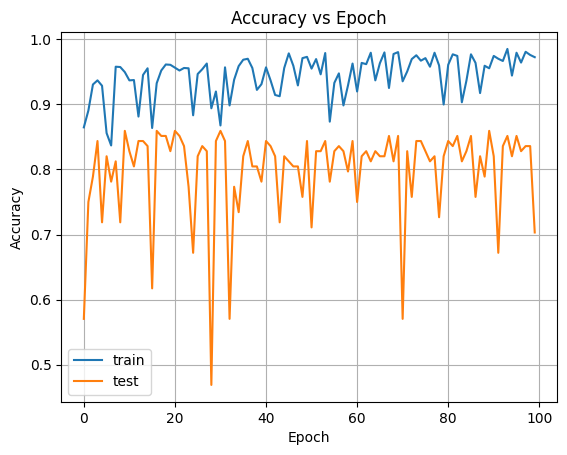

In [39]:
# ahora mostramos una grafica con la evolucion de la precision en el entrenamiento y en el test
plt.figure()
plt.plot(train_acc, label="train")
plt.plot(test_acc, label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.grid()
plt.show()


In [22]:
torch.save(model.state_dict(), "model_weights.pth")

In [23]:
model(torch.tensor([[1.0]]))

tensor([[0.8249, 0.1994]], grad_fn=<AddmmBackward0>)

ahora probamos como funciona para un x nuevo

In [24]:
u_test = torch.tensor(np.linspace(0.1, 4, 16).reshape((-1, 1)), dtype=torch.float64)
u_test

tensor([[0.1000],
        [0.3600],
        [0.6200],
        [0.8800],
        [1.1400],
        [1.4000],
        [1.6600],
        [1.9200],
        [2.1800],
        [2.4400],
        [2.7000],
        [2.9600],
        [3.2200],
        [3.4800],
        [3.7400],
        [4.0000]], dtype=torch.float64)

In [25]:
x_test = torch.cat([io.linprog(*plp_true(ui)).detach().t() for ui in u_test])
x_test

tensor([[-0.0200,  0.0200],
        [-0.0720,  0.0720],
        [ 0.9123,  0.1240],
        [ 0.8604,  0.1760],
        [ 0.7993,  0.2280],
        [ 0.7293,  0.2800],
        [ 0.6503,  0.3320],
        [ 0.5622,  0.3840],
        [ 0.4652,  0.4360],
        [ 0.3591,  0.4880],
        [ 0.2440,  0.5400],
        [ 0.1199,  0.5920],
        [-0.0133,  0.6440],
        [-0.6960,  0.9463],
        [-0.7480,  0.9445],
        [-0.8000,  0.9429]], dtype=torch.float64)

In [26]:
model.eval()

ParametricLPNet(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [27]:
u = torch.tensor([[0.25]], dtype=torch.float64)
x = torch.cat([io.linprog(*plp_true(ui)).detach().t() for ui in u])
u,x

(tensor([[0.2500]], dtype=torch.float64),
 tensor([[-0.0500,  0.0500]], dtype=torch.float64))

In [28]:
model(torch.tensor([[0.25]]))

tensor([[-0.0466,  0.0594]], grad_fn=<AddmmBackward0>)

In [29]:
x_pred = model(torch.tensor([[0.25]]))
x_pred

tensor([[-0.0466,  0.0594]], grad_fn=<AddmmBackward0>)

In [30]:
x, x_pred, torch.norm(x - x_pred)

(tensor([[-0.0500,  0.0500]], dtype=torch.float64),
 tensor([[-0.0466,  0.0594]], grad_fn=<AddmmBackward0>),
 tensor(0.0100, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>))

Revisar:
- Función de pérdida ✔️
- Función smooth_lp (a ver si puedo sustituir la funcion smooth_lp por la funcion de linprog de deep_inv_opt)
- Organizar y explicar el código
- Estudiar por qué no disminuye el loss cuando entreno el modelo: es porque está mostrando el loss en el conjunto de test y no en el de entrenamiento ✔️
- Entrenar el modelo con más épocas y datos
- Pensar qué optimizador es mejor ✔️
- Pensar qué estructura de la red es mejor ✔️
- Inicialización de los pesos de la red ✔️
- Arreglar el porcentaje de aciertos ✔️



Bitácora: ahora lo que pasa es que da error porque el problema de optimización no está acotado, lo que tengo que hacer es revisar en el paper el intervalo donde se mueve la u porque creo que lo he puesto mal. Cuando arregle esto, tengo que volver a entrenar el modelo y ver si se está entrenando bien. También tengo que probar resolviendo el problema de optimización con la función de linprog de deep_inv_opt y con la de cvxpy a ver si alguna de las dos funciona mejor.